In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import warnings
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_csv('./data/food_review_data.csv')
df = df[['review', 'y']]
# df.rename(columns={'review':'0', 'y':'1'}, inplace=True)
df

,review,y
0,친절하시고 깔끔하고 좋았습니다,1
1,조용하고 고기도 굿,1
2,"갈비탕과 냉면, 육회비빔밥이 맛있습니다.",1
3,대체적으로 만족하나\n와인의 구성이 살짝 아쉬움,1
4,고기도 맛있고 서비스는 더 최고입니다~,1
...,...,...
540,추웟어요 고기 외에는 별로에요..,0
541,고기질과 육전은 좋다.다만 한우손님 돼지고기 손님을 차별한다(돼지손님은 주차불가.네...,0
542,직접 구워주시고 진짜맛있음. 반찬도 맛있음. 직원분이 친절하게 잘해주시네요,1
543,친절하게 서빙해주시고 음식도 챙겨주셨어요 ㅎ,1


In [5]:
df['y'].value_counts()

1    492
0     53
Name: y, dtype: int64

In [6]:
# 미리 학습된 토크나이저 불러오기 
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def encode(sents, tokenizer):
    input_ids = [] # 각 문서를 구성하는 토큰의 ID 정보를 저장하는 리스트
    attention_masks = [] # 각 문서의 어텐션 마스크 정보를 저장하는 리스트
    for text in sents:
        tokenized_text = tokenizer.encode_plus(text,
                                            max_length=30,    # 문서 길이 30으로 통일
                                            add_special_tokens = True,    #[CLS], [SEP] 토큰 추가
                                            pad_to_max_length=True, 
#                                             padding_side='right',
                                            return_attention_mask=True)
        input_ids.append(tokenized_text['input_ids'])
        attention_masks.append(tokenized_text['attention_mask'])
    
    return tf.convert_to_tensor(input_ids, dtype=tf.int32), tf.convert_to_tensor(attention_masks, dtype=tf.int32)

In [7]:
tokenized_sents = encode(df['review'], tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [8]:
# 첫번째 리뷰의 토큰 ID 정보 
tokenized_sents[0][0]

<tf.Tensor: shape=(30,), dtype=int32, numpy=
array([   101,   9781,  58931,  35506,  14040,  11664,   8942, 118707,
        12453,   9685, 119118, 119081,  48345,    102,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0])>

In [9]:
# 첫번째 리뷰의 attention mask
tokenized_sents[1][0]

<tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])>

In [10]:
model = TFBertModel.from_pretrained('bert-base-multilingual-cased', output_hidden_states = True)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
for layer in model.layers:
    layer.trainable=False

In [12]:
# with tf.device('/GPU:0'):
outputs = model(tokenized_sents[0], attention_mask = tokenized_sents[1])

In [13]:
hidden_states = outputs.hidden_states

In [14]:
#마지막 인코더 블록의 정보만 사용 
hidden_states[-1]
hidden_states[-1].shape

# TensorShape([545, 30, 768])
# 545 = 리뷰의 수
# 30 = 각 리뷰를 구성하는 토큰 수
# 768 = 각 토큰을 구성하는 벡터 차원

TensorShape([545, 30, 768])

In [15]:
# CLS 토큰만 선택해서 numpy 배열로 -->독립변수 
features = hidden_states[-1][: ,0 , :].numpy()
features.shape

(545, 768)

In [16]:
features

array([[-0.17721301, -0.19821943, -0.01988322, ...,  0.27639383,
        -0.12252551,  0.16658491],
       [-0.14781961, -0.24631135, -0.25622016, ...,  0.16522296,
         0.05558657, -0.36443627],
       [-0.3651497 ,  0.02779552, -0.54583216, ...,  0.19339623,
         0.14297897,  0.11869855],
       ...,
       [-0.07919668, -0.04407279, -0.22303414, ...,  0.28185394,
         0.15880796,  0.07330315],
       [-0.12769486,  0.017923  , -0.82443863, ...,  0.57871306,
         0.09836257,  0.00239785],
       [ 0.02135136, -0.03048645, -0.33967245, ...,  0.63854516,
         0.15043807,  0.2676922 ]], dtype=float32)

In [17]:
#종속변수 지정 
selected_labels = df['y']

In [18]:
#train/test 나누기 
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, selected_labels, test_size=0.2, random_state=0)

In [19]:
#로지스틱 회귀 학습
from sklearn.linear_model import LogisticRegression

lr2 = LogisticRegression(C=0.1, penalty='l2', solver='saga', max_iter=1000)
lr2.fit(train_features, train_labels)
pred_labels = lr2.predict(test_features)

In [20]:
# 정확도 계산 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#accuracy_score(test_labels, pred_labels)
#confusion_matrix(test_labels, pred_labels)
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.90      1.00      0.95        98

    accuracy                           0.90       109
   macro avg       0.45      0.50      0.47       109
weighted avg       0.81      0.90      0.85       109



In [21]:
accuracy_score(test_labels, pred_labels)

0.8990825688073395

In [22]:
review = df['review']
y = df['y']

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(review, y, random_state=42, test_size=0.2)

In [25]:
from transformers import BertTokenizer, TFBertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def encode(data, tokenizer):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    for text in data:
        tokenized_text = tokenizer.encode_plus(text,
                                            max_length=50,
                                            add_special_tokens = True,
                                            pad_to_max_length=True,
                                            return_attention_mask=True,
                                            truncation=True)
        input_ids.append(tokenized_text['input_ids'])
        attention_masks.append(tokenized_text['attention_mask'])
        token_type_ids.append(tokenized_text['token_type_ids'])
    
    return input_ids, attention_masks, token_type_ids

In [26]:
train_input_ids, train_attention_masks, train_token_type_ids = encode(X_train, tokenizer)

#테스트 데이터
test_input_ids, test_attention_masks, test_token_type_ids = encode(X_test, tokenizer)

In [28]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_masks,
        }, label


def data_encode(input_ids_list, attention_mask_list, token_type_ids_list, label_list):
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)
    
BATCH_SIZE = 32
    
train_data_encoded = data_encode(train_input_ids, train_attention_masks, train_token_type_ids,y_train).shuffle(10000).batch(BATCH_SIZE)
test_data_encoded = data_encode(test_input_ids, test_attention_masks, test_token_type_ids, y_test).batch(BATCH_SIZE)

In [29]:
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2
)


optimizer = tf.keras.optimizers.Adam(1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

NUM_EPOCHS = 5
history = model.fit(train_data_encoded, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=test_data_encoded)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
14/14 [==============================] - 152s 9s/step - loss: 0.4233 - accuracy: 0.8784 - val_loss: 0.3018 - val_accuracy: 0.9083
Epoch 2/5
14/14 [==============================] - 130s 9s/step - loss: 0.3173 - accuracy: 0.9014 - val_loss: 0.2788 - val_accuracy: 0.9083
Epoch 3/5
14/14 [==============================] - 132s 9s/step - loss: 0.2902 - accuracy: 0.9014 - val_loss: 0.2613 - val_accuracy: 0.9083
Epoch 4/5
14/14 [==============================] - 136s 10s/step - loss: 0.2485 - accuracy: 0.9014 - val_loss: 0.2394 - val_accuracy: 0.9083
Epoch 5/5
14/14 [==============================] - 131s 9s/step - loss: 0.1920 - accuracy: 0.9289 - val_loss: 0.1843 - val_accuracy: 0.9358


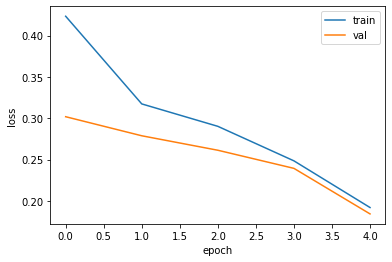

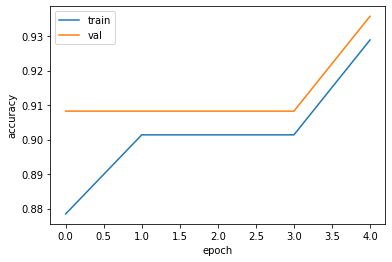

In [30]:
# loss 확인 
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()


# accuracy 확인 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()